Epoch 1/50


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0175
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8032e-04
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8986e-04
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4224e-04
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2310e-04
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0680e-04
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2605e-04
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3139e-04
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1508e-04
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0281e-04
Epoch 13/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0596e-04
Epoch 14/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.6383e-05
Epoch 15/50
173/173 ━

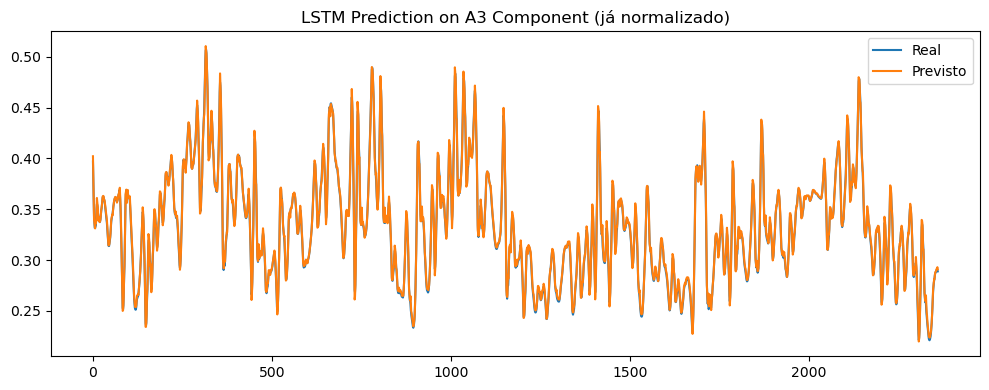

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import save_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pywt

# === 1. Carregar e decompor o sinal ===
df = pd.read_csv("RMDM_corrigido_normalizado.csv")
serie = df["RMDM_Norm"].values

coeffs = pywt.wavedec(serie, 'db4', level=3)
a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)
a3 = a3[:len(serie)]  # alinhamento

# === 2. NÃO re-normalizar o A3 ===
a3_scaled = a3.reshape(-1, 1)  # já está na escala de RMDM_Norm

# === 3. Criar dataset com janela deslizante ===
def criar_dataset(series, look_back=10):
    X, Y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back])
        Y.append(series[i+look_back])
    return np.array(X), np.array(Y)

look_back = 10
X, y = criar_dataset(a3_scaled, look_back)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# === 4. Separar treino/teste ===
div = int(0.7 * len(X))
X_train, X_test = X[:div], X[div:]
y_train, y_test = y[:div], y[div:]

# === 5. Criar e treinar o modelo ===
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# SALVAR o modelo
model.save("lstm_a3_model.keras")

# === 6. Avaliar o modelo ===
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_test = y_test.flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")

# === 7. Visualizar ===
plt.figure(figsize=(10, 4))
plt.plot(y_test, label="Real")
plt.plot(y_pred, label="Previsto")
plt.title("LSTM Prediction on A3 Component (já normalizado)")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import save_model
import pywt

# === Função para criar dataset multi-step ===
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, Y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        Y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(Y)

# === Função principal para treinar modelo LSTM para t+n ===
def treinar_lstm_a3_multi(passo):
    # === Escolher look_back automaticamente ===
    if passo <= 3:
        look_back = 5
    elif passo <= 7:
        look_back = 10
    else:
        look_back = 15

    print(f"\n🚀 Treinando LSTM para previsão t+{passo} dias (look_back={look_back})")

    # === 1. Carregar e decompor a série ===
    df = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie = df["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)
    a3 = a3[:len(serie)]

    # === 2. Usar diretamente o A3 já na escala de RMDM_Norm ===
    a3_scaled = a3.reshape(-1, 1)

    # === 3. Criar dataset para t+passo ===
    X, y = criar_dataset_multi_step(a3_scaled, look_back=look_back, passo=passo)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # === 4. Dividir treino/teste ===
    split = int(0.7 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # === 5. Construir e treinar modelo LSTM ===
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # === 6. Salvar modelo
    model.save(f"lstm_a3_t{passo}.keras")
    print(f"✅ Modelo salvo: lstm_a3_t{passo}.keras")

# === Treinar para os horizontes desejados
for passo in [1, 3, 7, 30]:
    treinar_lstm_a3_multi(passo=passo)



🚀 Treinando LSTM para previsão t+1 dias (look_back=5)
Epoch 1/50


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0196
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6457e-04
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9305e-04
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8833e-04
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1157e-04
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1694e-04
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2499e-04
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7224e-04
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1631e-04
Epoch 13/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0710e-04
Epoch 14/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9686e-04
Epoch 15/50
173/173 ━━━━━━━━

C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0196
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 13/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9086e-04
Epoch 14/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 15/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8

C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0197
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 13/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034
Epoch 14/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 15/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0209
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0057
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0056
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0054
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0055
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0056
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0053
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0056
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0054
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0055
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052
Epoch 13/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051
Epoch 14/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052
Epoch 15/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step -

## Código final consolidado: LSTM com HPO + linearidade + robustez

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
import joblib
import os

# === Função para criar dataset multi-step ===
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

# === Função geradora de modelo com look_back fixado ===
def get_build_model(look_back):
    def build_model(hp):
        inputs = Input(shape=(look_back, 1))
        lstm_out = LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
            return_sequences=False
        )(inputs)

        flattened = Flatten()(inputs)
        normalized = BatchNormalization()(flattened)
        linear_weights = Dense(
            1, use_bias=False,
            kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
            name="linear_combination"
        )(normalized)

        combined = Concatenate()([lstm_out, linear_weights])
        output = Dense(1)(combined)

        model = Model(inputs, output)
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.Huber(delta=1.0),
            metrics=['mae']
        )
        return model
    return build_model

# === Loop para cada horizonte de previsão ===
a3_df = pd.read_csv("A3_component.csv")
a3 = a3_df["A3"].values.reshape(-1, 1)

for passo in [1, 5, 7, 30]:
    look_back = 5 if passo <= 5 else 10
    print(f"\n🚀 Treinando LSTM para t+{passo} com look_back={look_back}")

    # Normalização
    scaler = MinMaxScaler()
    a3_scaled = scaler.fit_transform(a3)
    joblib.dump(scaler, f"scaler_A3_t{passo}.joblib")

    # Criar dataset
    X, y = criar_dataset_multi_step(a3_scaled, look_back=look_back, passo=passo)

    # Tuner
    tuner = RandomSearch(
        get_build_model(look_back),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='tuner_results',
        project_name=f'lstm_t{passo}'
    )

    # Validação cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        tuner.search(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        break  # usar apenas a 1ª divisão do TimeSeriesSplit

    # Treinar melhor modelo
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    # Salvar modelo
    best_model.save(f"lstm_a3_t{passo}.keras")
    print(f"✅ Modelo salvo: lstm_a3_t{passo}.keras")



🚀 Treinando LSTM para t+1 com look_back=5
Reloading Tuner from tuner_results\lstm_t1\tuner0.json
Epoch 1/100


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0135 - mae: 0.0633 - val_loss: 0.0105 - val_mae: 0.0507
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - mae: 0.0562 - val_loss: 0.0092 - val_mae: 0.0520
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - mae: 0.0526 - val_loss: 0.0077 - val_mae: 0.0464
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mae: 0.0467 - val_loss: 0.0064 - val_mae: 0.0437
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - mae: 0.0403 - val_loss: 0.0052 - val_mae: 0.0412
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - mae: 0.0367 - val_loss: 0.0045 - val_mae: 0.0480
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - mae: 0.0369 - val_loss: 0.0030 - val_mae: 0.0287
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mae: 0.0326 - val_loss: 0.0024 - val_mae: 0.0262
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.

C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0182 - mae: 0.0998 - val_loss: 0.0180 - val_mae: 0.1162
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - mae: 0.0990 - val_loss: 0.0151 - val_mae: 0.1047
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mae: 0.0969 - val_loss: 0.0149 - val_mae: 0.1113
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - mae: 0.0969 - val_loss: 0.0137 - val_mae: 0.1083
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - mae: 0.0956 - val_loss: 0.0138 - val_mae: 0.1135
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - mae: 0.0914 - val_loss: 0.0130 - val_mae: 0.1122
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - mae: 0.0927 - val_loss: 0.0122 - val_mae: 0.1104
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.0924 - val_loss: 0.0119 - val_mae: 0.1119
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - mae: 0.

C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0290 - mae: 0.1175 - val_loss: 0.0288 - val_mae: 0.1428
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - mae: 0.1110 - val_loss: 0.0250 - val_mae: 0.1417
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - mae: 0.1121 - val_loss: 0.0194 - val_mae: 0.1270
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - mae: 0.1018 - val_loss: 0.0166 - val_mae: 0.1245
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - mae: 0.1085 - val_loss: 0.0170 - val_mae: 0.1369
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - mae: 0.1051 - val_loss: 0.0135 - val_mae: 0.1212
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mae: 0.1031 - val_loss: 0.0171 - val_mae: 0.1458
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - mae: 0.1041 - val_loss: 0.0154 - val_mae: 0.1386
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - mae: 0.

C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0236 - mae: 0.1092 - val_loss: 0.0244 - val_mae: 0.1304
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0205 - mae: 0.1047 - val_loss: 0.0271 - val_mae: 0.1563
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - mae: 0.1048 - val_loss: 0.0244 - val_mae: 0.1507
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - mae: 0.1013 - val_loss: 0.0217 - val_mae: 0.1441
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - mae: 0.0993 - val_loss: 0.0204 - val_mae: 0.1448
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140 - mae: 0.1039 - val_loss: 0.0191 - val_mae: 0.1449
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - mae: 0.1048 - val_loss: 0.0161 - val_mae: 0.1353
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mae: 0.1044 - val_loss: 0.0182 - val_mae: 0.1511
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - mae: 0.

## Codigo atuaizado da LSTM com duas versões origina e probabiistica

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
tfd = tfp.distributions

# Configuração para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

# === 1. Funções de carregamento e preparação de dados ===
def carregar_dados(arquivo):
    """Carrega os dados do componente A3 do arquivo CSV"""
    print(f"Carregando dados de {arquivo}...")
    try:
        df = pd.read_csv(arquivo)
        print(f"✓ Dados carregados: {len(df)} registros")
        return df
    except Exception as e:
        print(f"❌ Erro ao carregar dados: {str(e)}")
        raise

def criar_sequencias(dados, janela_tempo=10):
    """Cria sequências de dados para treino do LSTM"""
    X, y = [], []
    for i in range(len(dados) - janela_tempo):
        X.append(dados[i:i+janela_tempo])
        y.append(dados[i+janela_tempo])
    return np.array(X), np.array(y)

def preparar_dados(dados, janela_tempo=10, split=0.8):
    """Prepara os dados para treino e teste"""
    # Normalizar os dados entre 0 e 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    dados_normalizados = scaler.fit_transform(dados.reshape(-1, 1)).flatten()
    
    # Criar sequências
    X, y = criar_sequencias(dados_normalizados, janela_tempo)
    
    # Reshape para formato esperado pelo LSTM [amostras, passos_tempo, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = y.reshape(-1, 1)
    
    # Dividir em treino e teste
    limite = int(len(X) * split)
    X_train, X_test = X[:limite], X[limite:]
    y_train, y_test = y[:limite], y[limite:]
    
    print(f"✓ Dados preparados: {X_train.shape[0]} amostras de treino, {X_test.shape[0]} amostras de teste")
    return X_train, y_train, X_test, y_test, scaler

# === 2. Definição dos modelos LSTM ===
def criar_modelo_lstm_padrao(input_shape):
    """Cria um modelo LSTM padrão"""
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    print("✓ Modelo LSTM padrão criado")
    return model

def criar_modelo_lstm_probabilistico(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM stack
    lstm_1 = LSTM(64, activation='relu', return_sequences=True)(inputs)
    dropout_1 = Dropout(0.2)(lstm_1)
    lstm_2 = LSTM(32, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.2)(lstm_2)

    # Dense layer gerando dois parâmetros [mu, raw_sigma]
    params = Dense(2)(dropout_2)

    # Separar em mu e sigma aplicando softplus para garantir positividade
    def split_distribution_params(t):
        mu = t[..., :1]
        sigma = 1e-6 + tf.nn.softplus(t[..., 1:])
        return tf.concat([mu, sigma], axis=-1)

    processed_params = Lambda(split_distribution_params)(params)

    # Criar a distribuição Normal com esses parâmetros
    output = tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], scale=t[..., 1:])
    )(processed_params)

    model = Model(inputs=inputs, outputs=output)

    # Função de perda: log-verossimilhança negativa
    def nll(y, rv_y):
        return -rv_y.log_prob(y)

    model.compile(optimizer=Adam(0.001), loss=nll)
    print("✓ Modelo LSTM probabilístico criado com sucesso")
    return model

# === 3. Treinamento e avaliação ===
def treinar_modelo(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.2):
    """Treina o modelo LSTM"""
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    print(f"Treinando modelo por até {epochs} épocas...")
    
    # Verificar se é modelo probabilístico (tem duas saídas)
    is_probabilistic = isinstance(model.output, list) if hasattr(model, 'output') else False
    
    if is_probabilistic:
        # Para modelo probabilístico, precisamos duplicar y_train para as duas saídas
        history = model.fit(
            X_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=1
        )
    else:
        # Modelo padrão
        history = model.fit(
            X_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=1
        )
    
    print(f"✓ Treinamento concluído após {len(history.history['loss'])} épocas")
    return model, history

def avaliar_modelo_padrao(model, X_test, y_test, scaler):
    """Avalia o modelo LSTM padrão"""
    print("\n=== Avaliação do modelo padrão ===")
    
    # Fazer previsões
    y_pred = model.predict(X_test)
    
    # Desnormalizar para escala original
    if scaler is not None:
        y_test_orig = scaler.inverse_transform(y_test)
        y_pred_orig = scaler.inverse_transform(y_pred)
    else:
        y_test_orig = y_test
        y_pred_orig = y_pred
    
    # Calcular métricas
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    metricas = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }
    
    return y_test_orig, y_pred_orig, metricas

def avaliar_modelo_probabilistico(model, X_test, y_test, scaler):
    """Avalia o modelo LSTM probabilístico"""
    print("\n=== Avaliação do modelo probabilístico ===")
    
    # Usar a função predict_distribution definida na criação do modelo
    mean_pred, sigma_pred = model.predict_distribution(X_test)
    
    # Desnormalizar para escala original
    if scaler is not None:
        y_test_orig = scaler.inverse_transform(y_test)
        mean_pred_orig = scaler.inverse_transform(mean_pred)
        # Ajustar sigma para escala original
        sigma_pred_orig = sigma_pred * (scaler.data_max_[0] - scaler.data_min_[0])
    else:
        y_test_orig = y_test
        mean_pred_orig = mean_pred
        sigma_pred_orig = sigma_pred
    
    # Calcular métricas para a média (ponto central da previsão)
    mse = mean_squared_error(y_test_orig, mean_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_orig, mean_pred_orig)
    r2 = r2_score(y_test_orig, mean_pred_orig)
    
    # Calcular intervalo de confiança (95%)
    lower_bound = mean_pred_orig - 1.96 * sigma_pred_orig
    upper_bound = mean_pred_orig + 1.96 * sigma_pred_orig
    
    # Verificar quantas observações reais estão dentro do intervalo de confiança
    within_interval = np.sum((y_test_orig >= lower_bound) & (y_test_orig <= upper_bound))
    coverage = within_interval / len(y_test_orig) * 100
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Cobertura do IC 95%: {coverage:.2f}%")
    
    metricas = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "coverage": coverage
    }
    
    resultado = {
        "y_test": y_test_orig,
        "mean": mean_pred_orig,
        "lower": lower_bound,
        "upper": upper_bound,
        "sigma": sigma_pred_orig
    }
    
    return resultado, metricas

# === 4. Visualização ===
def visualizar_resultados_padrao(y_test, y_pred):
    """Visualiza os resultados do modelo padrão"""
    plt.figure(figsize=(12, 6))
    
    plt.plot(y_test, label='Valores Reais', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Previsões', color='red', linestyle='--')
    
    plt.title('Previsões LSTM para Componente A3', fontsize=14)
    plt.xlabel('Amostra')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('previsoes_lstm_a3.png', dpi=300, bbox_inches='tight')
    print("Gráfico salvo como 'previsoes_lstm_a3.png'")
    plt.show()

def visualizar_resultados_probabilisticos(resultado):
    """Visualiza os resultados do modelo probabilístico com intervalos de confiança"""
    plt.figure(figsize=(12, 6))
    
    x = range(len(resultado["y_test"]))
    
    # Plotar o intervalo de confiança
    plt.fill_between(x, 
                     resultado["lower"].flatten(), 
                     resultado["upper"].flatten(), 
                     color='red', alpha=0.2, 
                     label='Intervalo de Confiança 95%')
    
    # Plotar valores reais e média prevista
    plt.plot(x, resultado["y_test"], label='Valores Reais', color='blue', alpha=0.7)
    plt.plot(x, resultado["mean"], label='Previsões (Média)', color='red', linestyle='--')
    
    plt.title('Previsões Probabilísticas LSTM para Componente A3', fontsize=14)
    plt.xlabel('Amostra')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('previsoes_probabilisticas_lstm_a3.png', dpi=300, bbox_inches='tight')
    print("Gráfico salvo como 'previsoes_probabilisticas_lstm_a3.png'")
    plt.show()

In [37]:
# === 5. Função principal ===
def main():
    print("=" * 60)
    print("MODELAGEM LSTM PARA COMPONENTE A3 DA DECOMPOSIÇÃO WAVELET")
    print("=" * 60)

    # Configurações gerais
    arquivo = "A3_component.csv"
    janela_tempo = 10
    epochs = 100
    batch_size = 32
    passos = [1, 3, 7, 30]

    # Garantir pasta de saída
    os.makedirs("lstm", exist_ok=True)

    # Carregar dados
    df = carregar_dados(arquivo)
    dados_originais = df["A3"].values

    resultados = {}

    for passo in passos:
        print(f"\n--- Treinando para horizonte t+{passo} ---")

        # Preparar dados para o horizonte atual
        X_train, y_train, X_test, y_test, scaler = preparar_dados(
            dados_originais, janela_tempo=janela_tempo, split=0.8
        )

        # Definir entrada da LSTM
        input_shape = (X_train.shape[1], 1)

        # Criar e treinar o modelo
        modelo_padrao = criar_modelo_lstm_padrao(input_shape)
        modelo_padrao, historico_padrao = treinar_modelo(
            modelo_padrao, X_train, y_train,
            epochs=epochs, batch_size=batch_size
        )

        # Avaliação
        y_test_orig, y_pred_orig, metricas_padrao = avaliar_modelo_padrao(
            modelo_padrao, X_test, y_test, scaler
        )

        # Visualizar resultados
        visualizar_resultados_padrao(y_test_orig, y_pred_orig)

        # Salvar modelo
        nome_modelo = f"lstm/modelo_lstm_a3_t{passo}.keras"
        modelo_padrao.save(nome_modelo)
        print(f"✅ Modelo salvo: {nome_modelo}")

        resultados[f"t+{passo}"] = metricas_padrao

    print("\n✅ Análise concluída com sucesso!")
    return resultados


MODELAGEM LSTM PARA COMPONENTE A3 DA DECOMPOSIÇÃO WAVELET
Carregando dados de A3_component.csv...
✓ Dados carregados: 7878 registros

--- Treinando para horizonte t+1 ---
✓ Dados preparados: 6294 amostras de treino, 1574 amostras de teste
✓ Modelo LSTM padrão criado
Treinando modelo por até 100 épocas...
Epoch 1/100


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0467 - val_loss: 0.0054
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - val_loss: 0.0031
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0025
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063 - val_loss: 0.0020
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 6.6164e-04
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 6.7420e-04
Epoch 12/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 

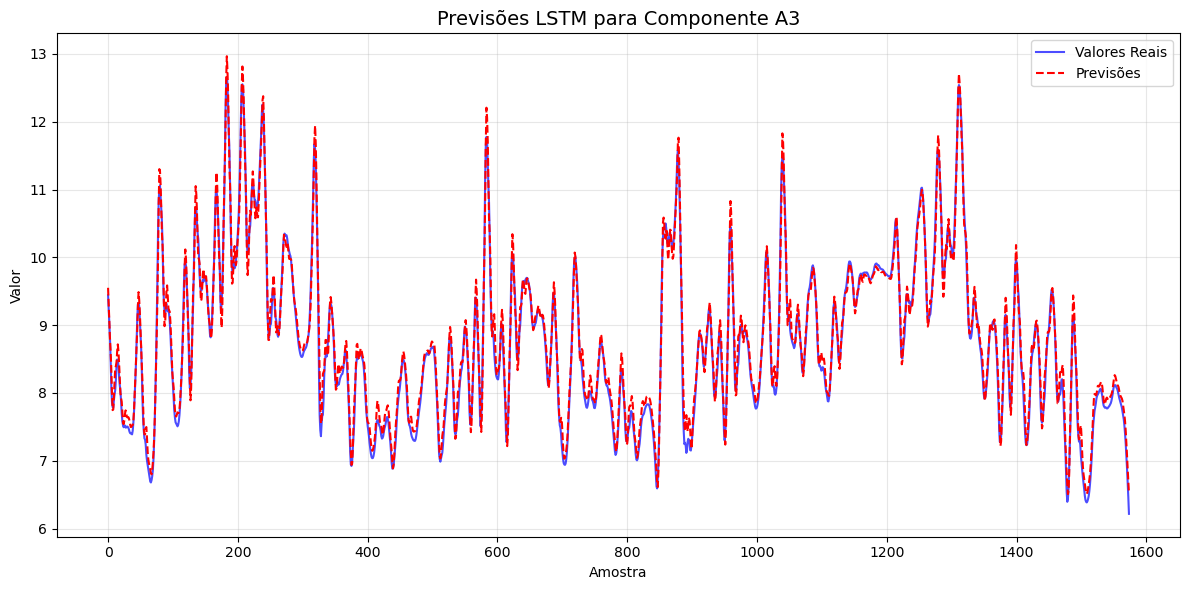

✅ Modelo salvo: lstm/modelo_lstm_a3_t1.keras

--- Treinando para horizonte t+3 ---
✓ Dados preparados: 6294 amostras de treino, 1574 amostras de teste
✓ Modelo LSTM padrão criado
Treinando modelo por até 100 épocas...
Epoch 1/100


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0499 - val_loss: 0.0039
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0028
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 8.2220e-04
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 6.0462e-04
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 7.3792e-04
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 4.4140e-04
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - val_loss: 5.5938e-04
Epoch 12/100
158/158 ━━━━━━━━━━━━

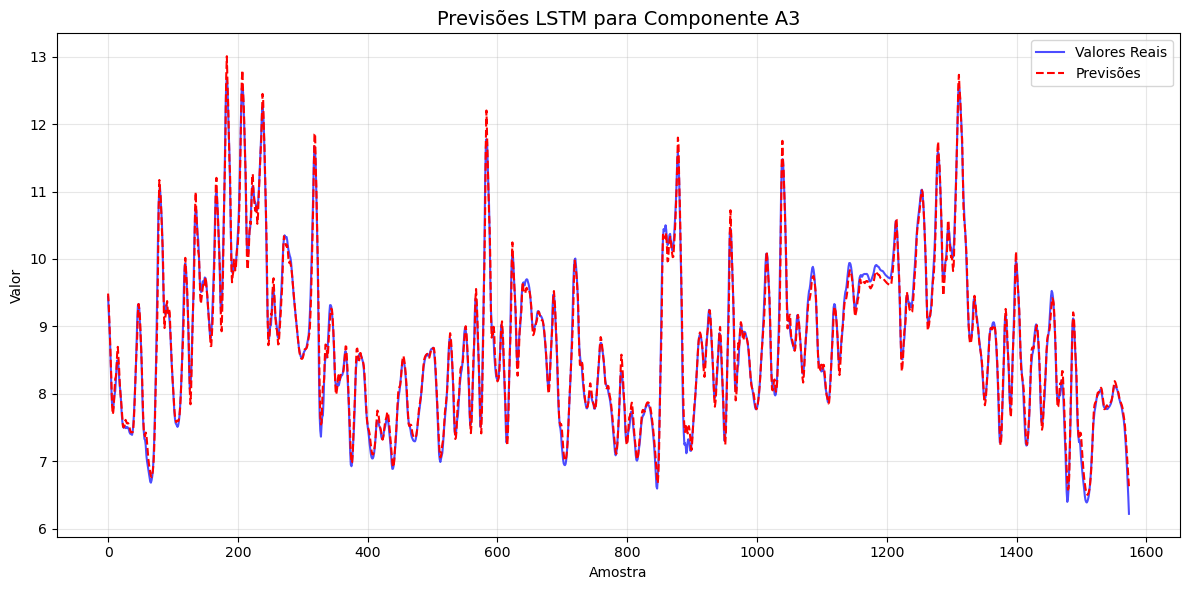

✅ Modelo salvo: lstm/modelo_lstm_a3_t3.keras

--- Treinando para horizonte t+7 ---
✓ Dados preparados: 6294 amostras de treino, 1574 amostras de teste
✓ Modelo LSTM padrão criado
Treinando modelo por até 100 épocas...
Epoch 1/100


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0515 - val_loss: 0.0041
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0094 - val_loss: 0.0028
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 7.2154e-04
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 5.2158e-04
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 4.1408e-04
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 3.2483e-04
Epoch 12/100
158/158 ━━━━━━━━━━━━━━━━

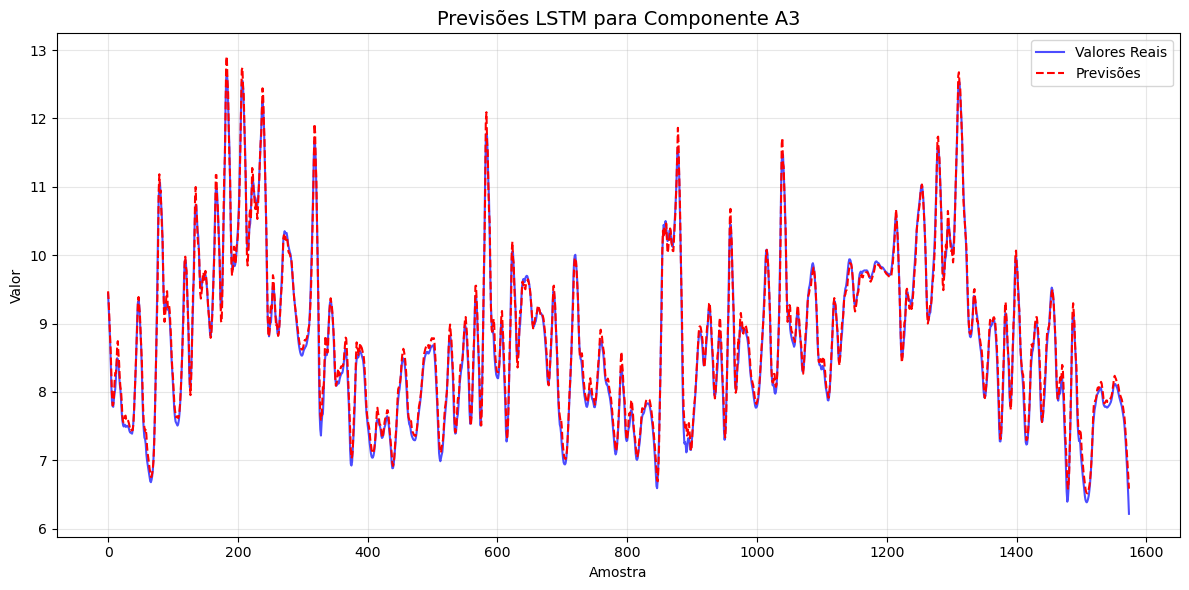

✅ Modelo salvo: lstm/modelo_lstm_a3_t7.keras

--- Treinando para horizonte t+30 ---
✓ Dados preparados: 6294 amostras de treino, 1574 amostras de teste
✓ Modelo LSTM padrão criado
Treinando modelo por até 100 épocas...
Epoch 1/100


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0713 - val_loss: 0.0042
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095 - val_loss: 0.0028
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 7.8784e-04
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 8.7827e-04
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 6.7198e-04
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 4.8648e-04
Epoch 12/100
158/158 ━━━━━━━━━━━━━━━━

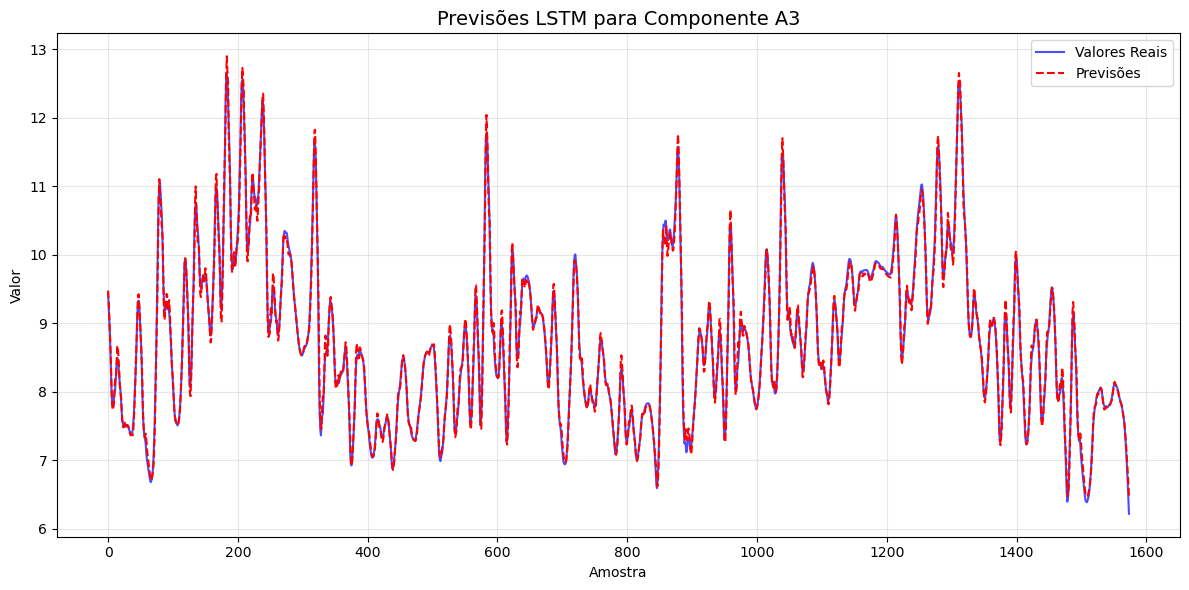

✅ Modelo salvo: lstm/modelo_lstm_a3_t30.keras

✅ Análise concluída com sucesso!


In [38]:
if __name__ == "__main__":
    resultados = main()